In [30]:
import math
import collections
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

from typing import Optional

import spectrum_utils.plot as sup
from spectrum_utils.spectrum import MsmsSpectrum

from falcon_ext.cluster import masking, similarity, cosine, clustering
from falcon_ext.preprocessing import preprocessing
from falcon_ext.ms_io import mgf_io
from falcon_ext import config
from falcon_ext.config import *

%matplotlib inline

In [3]:
spectrum_file = '../data/extracted_2d16b7f8-6954-4ba1-b5fa-3c467b43227d.mgf'

annotations_file = "../data/mouse_data/annotations.tsv"

config.parse([spectrum_file, annotations_file])

In [4]:
raw_spectra = mgf_io.get_spectra(source=spectrum_file)
spectra = list(preprocessing.process_all_spectra(raw_spectra, 
                                                config.min_peaks, config.min_mz_range,
                                                config.min_mz, config.max_mz,
                                                config.remove_precursor_tol,
                                                config.min_intensity, 
                                                config.max_peaks_used, config.scaling))
spectra = [spectrum for spectrum in spectra if spectrum is not None]
spectra.sort(key=lambda x: x.precursor_mz)

### Distance matrix 

In [5]:
distance_matrix_file = "../distance_matrix.npz"
distance_matrix = np.load(distance_matrix_file)["matrix"]

similarity_matrix = similarity.similarity_to_distance(distance_matrix)

mask = masking.generate_mask(spectra, config.precursor_tol[0], config.precursor_tol[1])
masked_distance_matrix = similarity.similarity_to_distance(np.multiply(similarity_matrix, mask))

In [76]:
from matplotlib.colors import LinearSegmentedColormap, hex2color, rgb2hex

def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))

colormap = LinearSegmentedColormap.from_list("", [hex2color("#364958"), hex2color("#3b6064"), hex2color("#55828b"), hex2color("#87bba2"), hex2color("#c9e4ca"), "honeydew"])

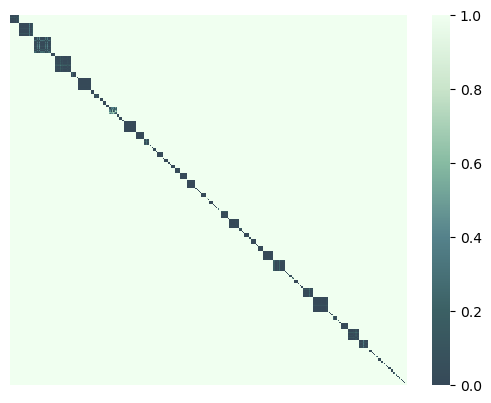

In [7]:
dist_matrix_plot = sns.heatmap(masked_distance_matrix, cmap=colormap, xticklabels=False, yticklabels=False)
fig = dist_matrix_plot.get_figure()
fig.savefig("../figures/distance_matrix.png", dpi=600)

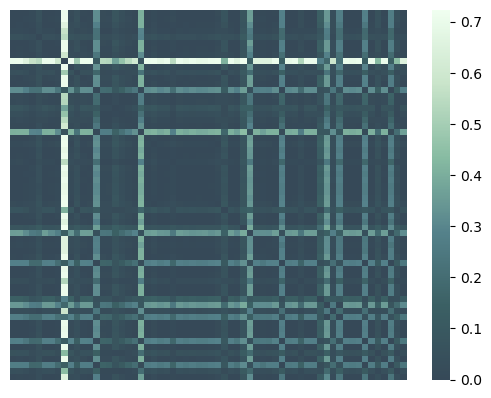

In [41]:
dist_matrix_plot_zoom = sns.heatmap(masked_distance_matrix[85:147, 85:147], cmap=colormap, xticklabels=False, yticklabels=False, cbar=True)
fig = dist_matrix_plot_zoom.get_figure()
fig.savefig("../figures/distance_matrix_zoom.png", dpi=600)

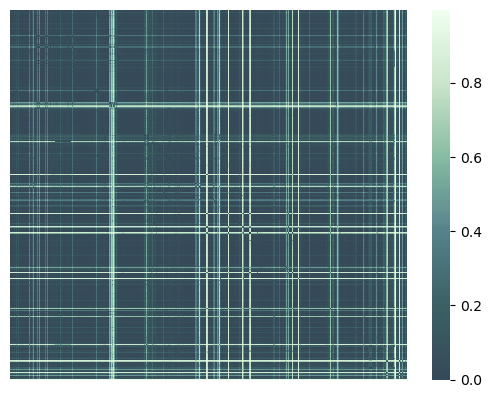

In [9]:
dist_matrix_plot = sns.heatmap(distance_matrix, cmap=colormap, xticklabels=False, yticklabels=False)

<Axes: >

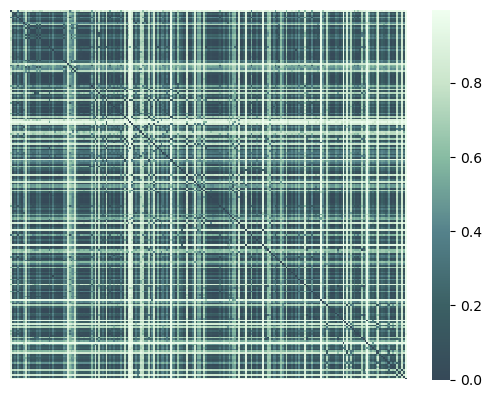

In [10]:
dist_slice = np.load('../distance_matrix_slice.npz')['matrix']
sns.heatmap(dist_slice, cmap=colormap, xticklabels=False, yticklabels=False)

<Axes: >

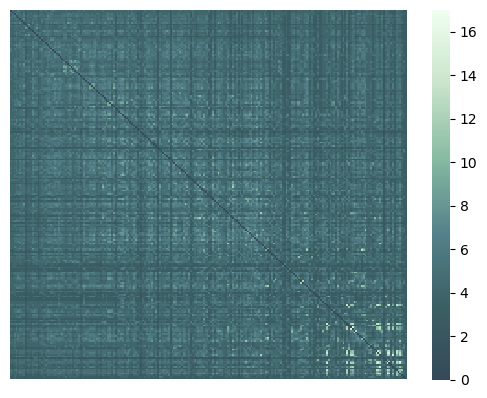

In [11]:
match_slice = np.load('../matches_matrix_slice.npz')['matrix']
sns.heatmap(match_slice, cmap=colormap, xticklabels=False, yticklabels=False)

In [12]:
FragmentAnnotation = collections.namedtuple("FragmentAnnotation", ["ion_type"])
FragmentAnnotation.__str__ = lambda _: ""


def plot_mirror(
    spectrum1: MsmsSpectrum,
    spectrum2: MsmsSpectrum,
    filename: str,
    fragment_mz_tol: float = 0.1,
) -> None:
    """
    Plot mirror spectra showing peak matches.

    Parameters
    ----------
    spectrum1 : sus.MsmsSpectrum
        The first spectrum.
    spectrum2 : sus.MsmsSpectrum
        The second spectrum.
    score : Optional[str]
        The similarity score used. Valid values are `None`, "cosine",
        "modified_cosine", and "neutral_loss".
    filename : str
        Filename to save the figure.
    fragment_mz_tol : float
        The fragment mass tolerance to match peaks to each other
        (default: 0.1).
    """
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex="all", figsize=(8, 8))

    score = "modified_cosine"
    sim = cosine.modified_cosine(spectrum1, spectrum2, fragment_mz_tol)
    title = f"Modified cosine similarity = {sim[0]:.4f}"

    _annotate_matching_peaks(
        spectrum1,
        spectrum2,
        sim.matched_indices if sim is not None else None,
        sim.matched_indices_other if sim is not None else None,
        fragment_mz_tol,
    )

    # Draw lines between matching peaks.
    if sim is not None:
        for mz1, mz2 in zip(
            spectrum1.mz[sim.matched_indices],
            spectrum2.mz[sim.matched_indices_other],
        ):
            ion_type = "b" if abs(mz1 - mz2) < fragment_mz_tol else "y"
            axes[0].plot(
                [mz1, mz2],
                [0, -0.4],
                c=sup.colors[ion_type],
                ls="dotted",
                clip_on=False,
                zorder=10,
            )

    sup.spectrum(spectrum1, ax=axes[0], grid=False)
    sup.spectrum(spectrum2, ax=axes[1], mirror_intensity=True, grid=False)

    mz_margin = 20
    min_mz = min(spectrum1.mz[0], spectrum2.mz[0])
    max_mz = max(spectrum1.mz[-1], spectrum2.mz[-1])
    min_mz = max(0, math.floor(min_mz / mz_margin - 1) * mz_margin)
    max_mz = math.ceil(max_mz / mz_margin + 1) * mz_margin
    axes[0].set_xlim(min_mz, max_mz)

    axes[0].set_ylim(0, 1.05)
    axes[1].set_ylim(-1.05, 0)

    axes[0].set_xlabel("")
    if score == "neutral_loss":
        axes[1].set_xlabel("Δm/z", style="italic")
    axes[0].set_ylabel("")
    axes[1].set_ylabel("")
    fig.text(0.04, 0.5, "Intensity", va="center", rotation="vertical")
    axes[1].yaxis.set_major_formatter(
        mticker.FuncFormatter(lambda x, pos: f"{abs(x):.0%}")
    )

    axes[0].set_title(title)

    plt.subplots_adjust(hspace=0.4)

    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.close()


def _annotate_matching_peaks(
    spectrum1: MsmsSpectrum,
    spectrum2: MsmsSpectrum,
    peak_matches1: np.ndarray,
    peak_matches2: np.ndarray,
    fragment_mz_tol: float,
) -> None:
    """
    Somewhat hacky way to get spectrum_utils to annotate matching peaks.

    Parameters
    ----------
    spectrum1 : sus.MsmsSpectrum
        The first spectrum.
    spectrum2 : sus.MsmsSpectrum
        The second spectrum.
    peak_matches1 : np.ndarray
        Matching peak indexes in the first spectrum.
    peak_matches2 : np.ndarray
        Matching peak indexes in the second spectrum.
    fragment_mz_tol : float
        The fragment mass tolerance to match peaks to each other.
    """
    if peak_matches1 is None or peak_matches2 is None:
        return
    spectrum1._annotation = np.full_like(spectrum1.mz, None, object)
    spectrum2._annotation = np.full_like(spectrum2.mz, None, object)
    for match1, match2 in zip(peak_matches1, peak_matches2):
        ion_type = (
            "b"
            if abs(spectrum1.mz[match1] - spectrum2.mz[match2])
            < fragment_mz_tol
            else "y"
        )
        spectrum1._annotation[match1] = FragmentAnnotation(ion_type=ion_type)
        spectrum2._annotation[match2] = FragmentAnnotation(ion_type=ion_type)

In [13]:
plot_mirror(spectra[991], spectra[998], "../figures/mirror_plot.png", config.fragment_tol)
plt.show()

### Clustering

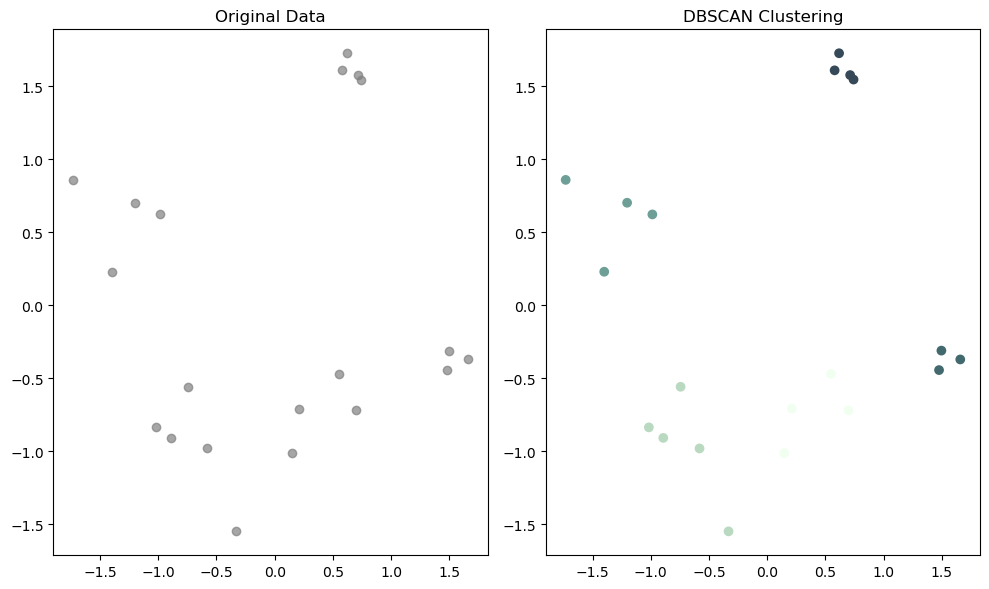

In [104]:
from sklearn.datasets import make_blobs
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Generate synthetic data with distinct clusters and some noise
data, _ = make_blobs(n_samples=10, centers=3, cluster_std=0.2, random_state=0)
noise = np.random.normal(size=(10, 2))  # Adding some noise
data = np.vstack([data, noise])

# Standardize the data (important for DBSCAN)
data = StandardScaler().fit_transform(data)

# Apply DBSCAN
dbscan = DBSCAN(eps=0.7, min_samples=3)
labels = dbscan.fit_predict(data)

# Plot the results
plt.figure(figsize=(10, 6))

# Plot the original data
plt.subplot(1, 2, 1)
plt.scatter(data[:, 0], data[:, 1], c='gray', alpha=0.7)
plt.title('Original Data')

# Plot the DBSCAN results
plt.subplot(1, 2, 2)
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap=colormap)
plt.title('DBSCAN Clustering')

plt.tight_layout()
plt.show()

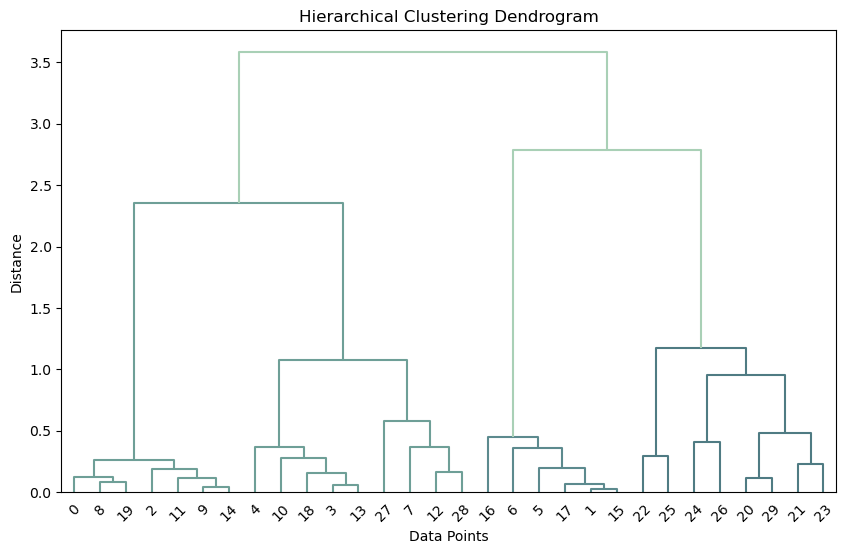

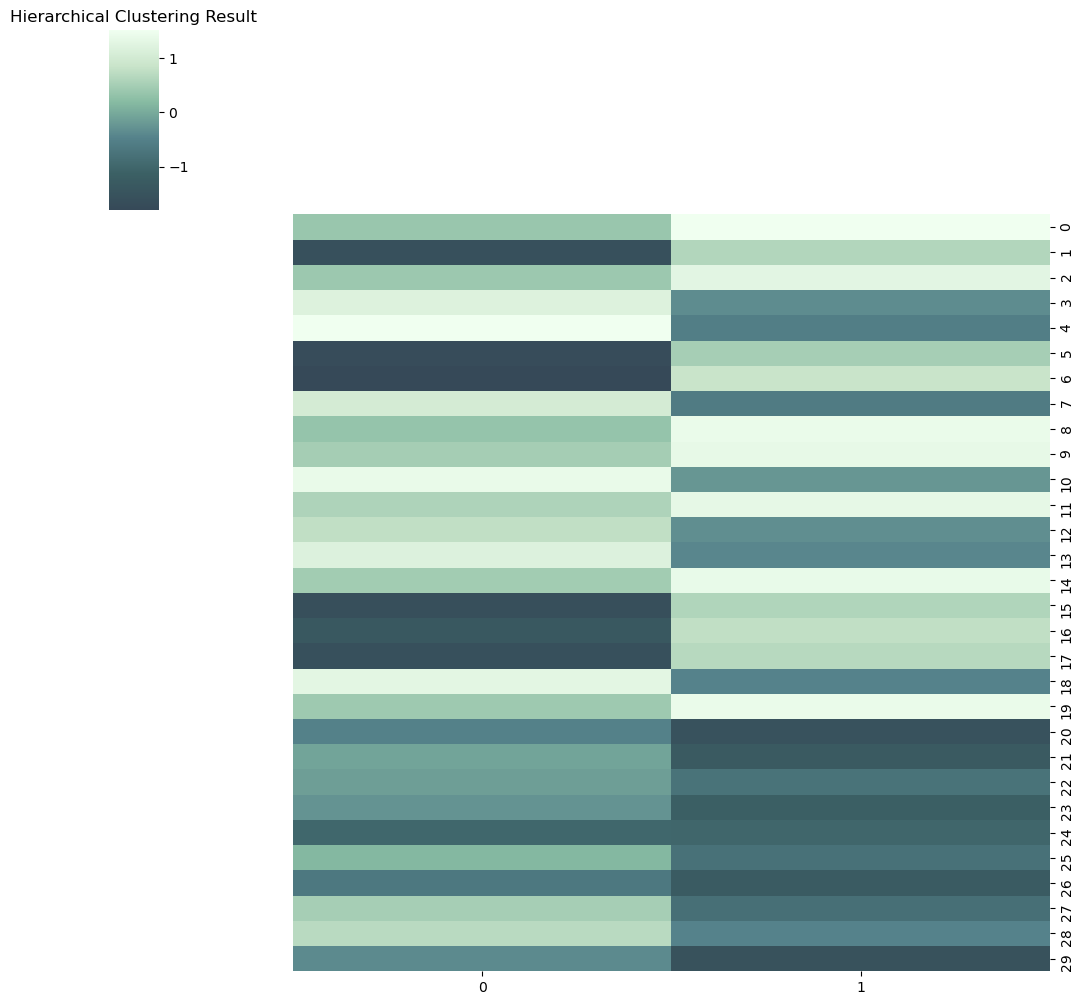

In [96]:
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import linkage, dendrogram
import seaborn as sns

linkage_matrix = linkage(data, method='complete')

hierarchy.set_link_color_palette([rgb2hex(colormap(x)) for x in np.linspace(0, 0.5, 8)[::-1]])

# Plot the dendrogram
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix, above_threshold_color=rgb2hex(colormap(0.7)))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()

# Optional: Visualize the clustering result using seaborn
sns.clustermap(data, method='ward', cmap=colormap, row_cluster=False, col_cluster=False)
plt.title('Hierarchical Clustering Result')
plt.show()